<a href="https://colab.research.google.com/github/ksulaiman1/MCS7204-Deep-Learning-Project/blob/main/chest_opacity_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import pathlib
import random
from tqdm import tqdm
from random import sample
import itertools
import shutil

# from fastai.vision import *
# from fastai.metrics import error_rate, accuracy

import tensorflow as tf
import torch
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.optimizers import adam_v2
from tensorflow.keras.preprocessing import image
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, SeparableConv2D, GlobalAveragePooling2D, Input, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers, layers, optimizers
from tensorflow.keras.applications import ResNet50V2, Xception, ResNet101V2, VGG16, EfficientNetV2S

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd drive/MyDrive/deep_learning/dataset1

/content/drive/MyDrive/deep_learning/dataset1


In [4]:
train_data = []
for img in glob.glob('known_images/normal/*.png'):
  train_data.append((img,0))

for img in glob.glob('known_images/sick/*.png'):
  train_data.append((img, 1))

In [5]:
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

In [6]:
train_data['label'].value_counts()

0    364
1    351
Name: label, dtype: int64

In [7]:
train_data

,image,label
0,known_images/normal/normal_299.png,0
1,known_images/normal/normal_240.png,0
2,known_images/normal/normal_26.png,0
3,known_images/normal/normal_672.png,0
4,known_images/normal/normal_3.png,0
...,...,...
710,known_images/sick/sick_33.png,1
711,known_images/sick/sick_250.png,1
712,known_images/sick/sick_60.png,1
713,known_images/sick/sick_201.png,1


In [8]:
train_data = train_data.drop([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 700], axis=0)

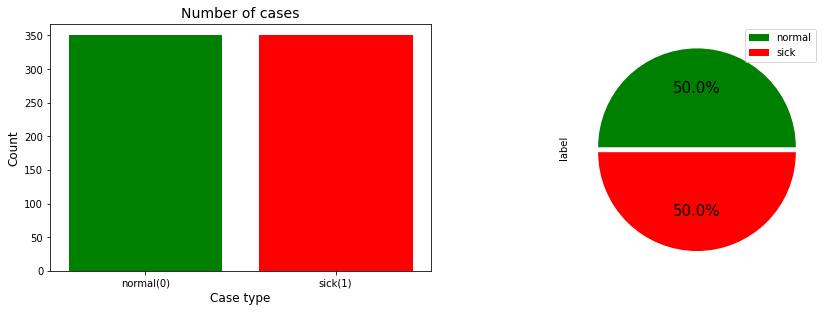

In [ ]:
cases_count = train_data['label'].value_counts()
# Plot the results 
plt.figure(figsize=(15,10))
plt.subplot(221)
ax = sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['normal(0)', 'sick(1)'])

ax.patches[0].set_color('green')
ax.patches[1].set_color('red')

plt.subplot(222)
train_data['label'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['green','red'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['normal', 'sick'])
plt.show()

In [ ]:
sick_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = normal_samples + sick_samples
# del sick_samples, normal_samples

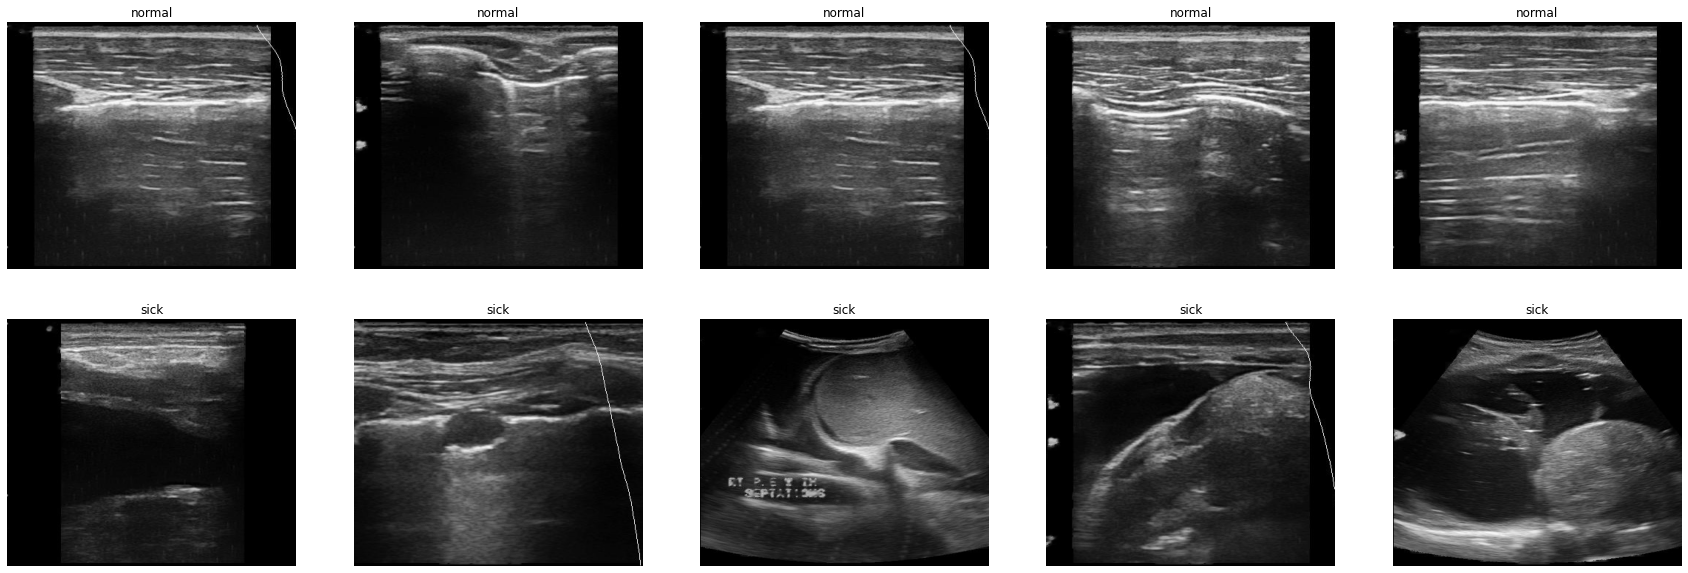

In [ ]:
# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = Image.open(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    else:
        ax[i//5, i%5].set_title(samples[i].split("/")[1])
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [9]:
train_set, valid_set = train_test_split(train_data, test_size=0.2, random_state=0, stratify=train_data.label)
train_set, test_set = train_test_split(train_set, test_size=0.2, random_state=0, stratify=train_set.label)

In [ ]:
train_set.shape, valid_set.shape, test_set.shape

((448, 2), (140, 2), (112, 2))

In [ ]:
train_set['label'].value_counts()

0    224
1    224
Name: label, dtype: int64

In [ ]:
valid_set['label'].value_counts()

1    70
0    70
Name: label, dtype: int64

In [ ]:
test_set['label'].value_counts()

1    56
0    56
Name: label, dtype: int64

In [ ]:
os.makedirs('train/normal')
os.makedirs('train/sick')
os.makedirs('valid/normal')
os.makedirs('valid/sick')
os.makedirs('test/normal')
os.makedirs('test/sick')

In [10]:
train_normal = 'train/normal'
train_sick = 'train/sick'

valid_normal = 'valid/normal'
valid_sick = 'valid/sick'

test_normal = 'test/normal'
test_sick = 'test/sick'

In [ ]:
for img in tqdm(train_set[train_set['label']==0]['image'], 'Copying normal images: '):
  shutil.copy(img, train_normal)

for img in tqdm(train_set[train_set['label']==1]['image'], 'Copying sick images: '):
  shutil.copy(img, train_sick)

for img in tqdm(valid_set[valid_set['label']==0]['image'], 'Copying normal images: '):
  shutil.copy(img, valid_normal)
train_normal = 'train/normal'

for img in tqdm(valid_set[valid_set['label']==1]['image'], 'Copying sick images: '):
  shutil.copy(img, valid_sick)

for img in tqdm(test_set[test_set['label']==0]['image'], 'Copying normal images: '):
  shutil.copy(img, test_normal)

for img in tqdm(test_set[test_set['label']==1]['image'], 'Copying normal images: '):
  shutil.copy(img, test_sick)

Copying normal images: 100%|██████████| 56/56 [00:00<00:00, 164.92it/s]


In [ ]:
print(len(glob.glob("train/normal/*")))
print(len(glob.glob("train/sick/*")))

print(len(glob.glob("valid/normal/*")))
print(len(glob.glob("valid/sick/*")))

print(len(glob.glob("test/normal/*")))
print(len(glob.glob("test/sick/*")))

224
224
70
70
56
56


In [11]:
class_names =['normal', 'sick']
class_label = {class_name: i for i, class_name in enumerate(class_names)}
print (class_label)

{'normal': 0, 'sick': 1}


In [12]:
IMAGE_SIZE =(150, 150)

def load_data():
  Directory ='/content/drive/MyDrive/deep_learning/dataset1'
  Category = ["train","test", "valid"]
  output = []

  for category in Category:
    path = os.path.join(Directory, category)
    images =[]
    labels =[]

    for  folder in tqdm(os.listdir(path), desc="Loading {}".format(category)):
      label = class_label[folder]

      for file in os.listdir(os.path.join(path, folder)):
        img_path = os.path.join(os.path.join(path, folder), file)

        image =cv2.imread(img_path,0)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # blur_img = cv2.blur(image, (3,3), 0)
        image = cv2.resize(image, IMAGE_SIZE)
      
        
        images.append(image)
        labels.append(label)     
      
    
    images = np.array(images)
    labels =np.array(labels, dtype ='int32')

    output.append((images, labels))
  
  return output

In [13]:
(train_images, train_labels), (test_images, test_labels), (valid_images, valid_labels) =load_data()

Loading valid: 100%|██████████| 2/2 [00:39<00:00, 19.92s/it]


In [15]:
train_images.shape, train_labels.shape , valid_images.shape, valid_labels.shape, test_images.shape, test_labels.shape

((448, 150, 150, 3),
 (448, 2),
 (140, 150, 150, 3),
 (140, 2),
 (112, 150, 150, 3),
 (112, 2))

In [16]:
train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)
test_labels = to_categorical(test_labels)

# Data Augmentation

In [17]:
trainAug = ImageDataGenerator(
              rescale = 1./255,
              # horizontal_flip=True,
              # vertical_flip=True,
              # shear_range=0.2,
              # zoom_range=0.2,
              # rotation_range=.2, 
              # width_shift_range=0.2,
              # height_shift_range=0.2,
              # fill_mode='nearest',
              # preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
              ) 

validAug = ImageDataGenerator(
     rescale = 1./255,
              ) 
    
trainData = trainAug.flow(
    train_images, 
    train_labels,
    batch_size=32,

    )

validData =validAug.flow(
    valid_images, 
    valid_labels,
    batch_size=32,
        )

testData =validAug.flow(
    test_images, 
    test_labels,
    batch_size=32,
    shuffle = False
        )

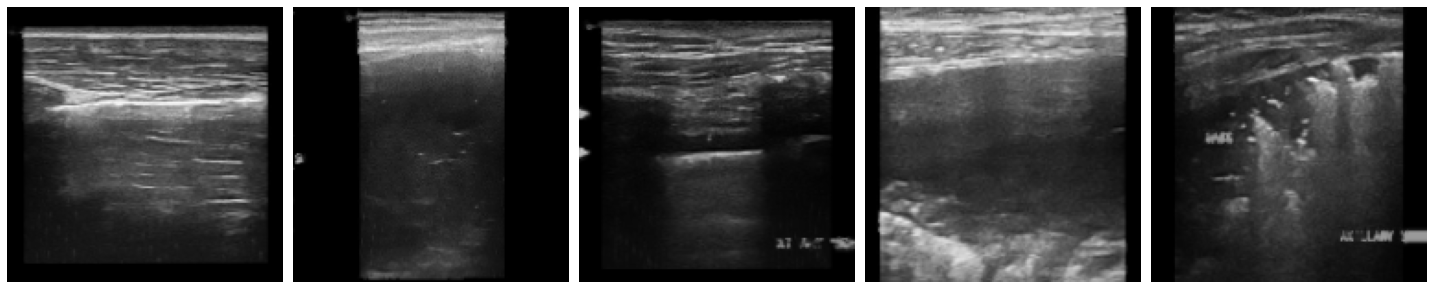

In [ ]:
imgs, labels = next(trainData)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)

In [ ]:
base_model = tf.keras.applications.ResNet50V2(weights = "imagenet", input_shape = (150, 150, 3), include_top = False, pooling='max')

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = tf.keras.layers.Dense(16,activation='relu')(x)
predictions = tf.keras.layers.Dense(2,activation='softmax')(x)

model1= tf.keras.Model(base_model.input,predictions)

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
tf.keras.utils.plot_model(
    model1, show_layer_names=True, show_shapes=True)
   

In [ ]:
filepath = "opacity_model.h5"
    
callbacks = [ 
    ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2, min_delta=1e-7),
            #  EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-7),
             ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

model1.compile(optimizer =optimizers.Adam(learning_rate=1e-4), loss = "categorical_crossentropy", metrics = ["accuracy", 'AUC'])



In [ ]:
hist = model1.fit(trainData, validation_data= validData, epochs=70, batch_size=32, callbacks=callbacks)


Epoch 1/70
14/14 [==============================] - 6s 245ms/step - loss: 1.5066 - accuracy: 0.5335 - auc: 0.5217 - val_loss: 1.0200 - val_accuracy: 0.6286 - val_auc: 0.6489 - lr: 1.0000e-04
Epoch 2/70
14/14 [==============================] - 2s 127ms/step - loss: 0.7860 - accuracy: 0.6830 - auc: 0.7440 - val_loss: 0.6382 - val_accuracy: 0.7214 - val_auc: 0.8035 - lr: 1.0000e-04
Epoch 3/70
14/14 [==============================] - 2s 127ms/step - loss: 0.4936 - accuracy: 0.7812 - auc: 0.8655 - val_loss: 0.4908 - val_accuracy: 0.8071 - val_auc: 0.8702 - lr: 1.0000e-04
Epoch 4/70
14/14 [==============================] - 2s 127ms/step - loss: 0.3651 - accuracy: 0.8438 - auc: 0.9199 - val_loss: 0.3970 - val_accuracy: 0.8357 - val_auc: 0.9130 - lr: 1.0000e-04
Epoch 5/70
14/14 [==============================] - 2s 125ms/step - loss: 0.2853 - accuracy: 0.8839 - auc: 0.9502 - val_loss: 0.3466 - val_accuracy: 0.8714 - val_auc: 0.9316 - lr: 1.0000e-04
Epoch 6/70
14/14 [===========================

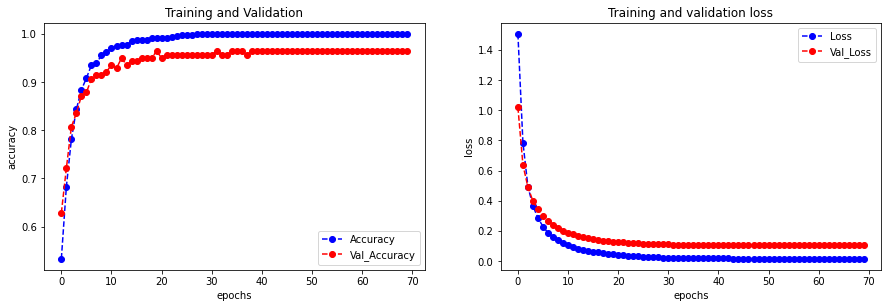

In [ ]:
fig = plt.figure(figsize =(15, 10))

plt.subplot(221)
plt.plot(hist.history['accuracy'],'bo--', label ='Accuracy')
plt.plot(hist.history['val_accuracy'],'ro--', label ='Val_Accuracy')
plt.title("Training and Validation")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(hist.history['loss'],'bo--', label ='Loss')
plt.plot(hist.history['val_loss'],'ro--', label ='Val_Loss')
plt.title("Training and validation loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()
plt.show()

In [ ]:
model1.evaluate(testData)

4/4 [==============================] - 0s 62ms/step - loss: 0.1388 - accuracy: 0.9464 - auc: 0.9898


[0.13880686461925507, 0.9464285969734192, 0.9897959232330322]

In [ ]:
predict_labels = np.argmax(model1.predict(testData), axis=1)
true_labels = np.argmax(testData.y, axis=1)

In [ ]:
print(classification_report(true_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        56
           1       0.95      0.95      0.95        56

    accuracy                           0.95       112
   macro avg       0.95      0.95      0.95       112
weighted avg       0.95      0.95      0.95       112



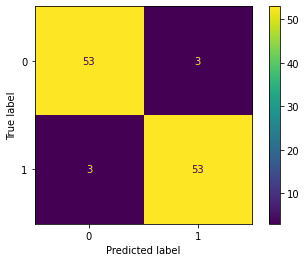

In [ ]:
cm = confusion_matrix(true_labels, predict_labels)
cm_plot_labels = ['normal','sick']
ConfusionMatrixDisplay(cm).plot()

## Load saved model

In [18]:
model = tf.keras.models.load_model('opacity_model.h5')

## Unknown Images

In [ ]:
folder_path = 'unknown_images/unknown_images'
IMAGE_SIZE =(150, 150)

def load_data():
  directory ='/content/drive/MyDrive/deep_learning/dataset1/unknown_images/unknown_images/'
  # Category = ["unknown_images"]
  output = []
  images = []

  for file in tqdm(os.listdir(directory), desc='lOADING UNKNOWN_IMAGES: '):
    img_path = os.path.join(directory, file)
    image =cv2.imread(img_path,0)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # blur_img = cv2.blur(image, (3,3), 0)
    image = cv2.resize(image, IMAGE_SIZE)
    image = np.array(image)
    images.append(image)
    # labels.append(label)     
  # images = np.array(images)
  # labels =np.array(labels, dtype ='int32')

  # output.append(images)
  
  return images

In [ ]:
unknown = load_data()

lOADING UNKNOWN_IMAGES: 100%|██████████| 50/50 [00:00<00:00, 137.03it/s]


In [ ]:
unknown_images = np.array(unknown)
print(unknown_images.shape)

# unknown_images =validAug.flow(
#     x =unknown_images , 
#     y = None,
#     batch_size=32,
#     shuffle = False
#         )

In [ ]:
unknown_images =validAug.flow(
    x =unknown_images , 
    y = None,
    batch_size=32,
    shuffle = False
        )

In [ ]:
unknown_predictions = model.predict(unknown_images)
unknown_labels = np.argmax(unknown_predictions, axis=1)

In [ ]:
unknown_labels

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0])

## Save predicted labels and image names as csv

In [ ]:
directory ='/content/drive/MyDrive/deep_learning/dataset1/unknown_images/unknown_images/'
image_name = os.listdir(directory)

In [ ]:
unknown_csv = pd.DataFrame({'Unknown_images':image_name, 'Diagnosis':unknown_labels})

In [ ]:
unknown_csv.sort_values(by=['Unknown_images'], inplace=True)

In [ ]:
unknown_csv = unknown_csv.reset_index(drop=True)
unknown_csv['Diagnosis'].replace({0: "normal", 1:'sick'}, inplace=True)

In [ ]:
unknown_csv

,Unknown_images,Diagnosis
0,01.png,normal
1,02.png,sick
2,03.png,normal
3,04.png,sick
4,05.png,normal
5,06.png,sick
6,07.png,normal
7,08.png,sick
8,09.png,normal
9,10.png,sick


In [ ]:
unknown_csv.to_csv('unknown_csv.csv', index=False)

# Dataset 2

In [ ]:
!pwd

/content/drive/MyDrive/deep_learning/dataset1


In [19]:
IMAGE_SIZE =(150, 150)

def load_data():
  directory ='/content/drive/MyDrive/deep_learning/dataset2/images'
  images = []
  output = []
  image_name = []

  for file in tqdm(os.listdir(directory), desc='LOADING DATASET2 IMAGES: '):
    img_path = os.path.join(directory, file)
    image_name.append(img_path.split("/")[-1])
    image = cv2.imread(img_path,0)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    # image = cv2.equalizeHist(image)
    # image = cv2.medianBlur(image, 3)

    # image = cv2.blur(image, (3,3), 0)
    image = cv2.resize(image, IMAGE_SIZE)
    image = np.array(image)
    images.append(image)
    # labels.append(label)     
  # images = np.array(images)
  # labels =np.array(labels, dtype ='int32')
  # image_name = np.array(image_name)
  # output.append((images, image_name))
  return images, image_name

In [20]:
dataset2, dataset2_names = load_data()

LOADING DATASET2 IMAGES: 100%|██████████| 224/224 [00:02<00:00, 79.58it/s] 


In [21]:
dataset2_images = np.array(dataset2)
dataset2_images.shape

(224, 150, 150, 3)

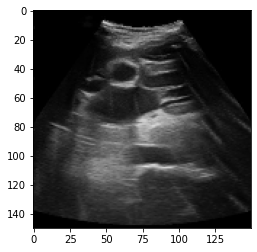

In [ ]:
plt.imshow(dataset2_images[4])

In [22]:
dataset2_names

['sick_eif23.png',
 'sick_eif85.png',
 'sick_eif98.png',
 'sick_eif70.png',
 'sick_eff79.png',
 'sick_eif55.png',
 'sick_eff48.png',
 'sick_eff83.png',
 'sick_eif97.png',
 'sick_eff14.png',
 'sick_eff52.png',
 'sick_eff25.png',
 'sick_eif62.png',
 'sick_eif96.png',
 'sick_eif95.png',
 'sick_eff100.png',
 'sick_eif77.png',
 'sick_eff55.png',
 'sick_eif42.png',
 'sick_eif19.png',
 'sick_eif93.png',
 'sick_eif4.png',
 'sick_eff23.png',
 'sick_eff71.png',
 'sick_eff76.png',
 'sick_eff61.png',
 'sick_eif37.png',
 'sick_eif38.png',
 'sick_eif53.png',
 'sick_eff107.png',
 'sick_eff10.png',
 'sick_eff94.png',
 'sick_eif101.png',
 'sick_eif50.png',
 'sick_eff34.png',
 'sick_eff43.png',
 'sick_eif28.png',
 'sick_eif94.png',
 'sick_eff51.png',
 'sick_eif84.png',
 'sick_eff60.png',
 'sick_eff9.png',
 'sick_eff54.png',
 'sick_eif68.png',
 'sick_eff8.png',
 'sick_eif91.png',
 'sick_eff18.png',
 'sick_eif87.png',
 'sick_eff82.png',
 'sick_eff93.png',
 'sick_eff33.png',
 'sick_eff110.png',
 'sick_eff3

In [23]:
dataset2_labels = pd.read_csv('/content/drive/MyDrive/deep_learning/dataset2/image_classes.csv')
# dataset2_csv.sort_values(by=['patient'], inplace=True)

In [24]:
dataset2_labels

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0,0
1,sick_eff1,0
2,sick_eff2,0
3,sick_eff3,0
4,sick_eff4,0
...,...,...
219,sick_eif107,1
220,sick_eif108,1
221,sick_eif109,1
222,sick_eif110,1


In [ ]:
dataset2_labels.dtypes

patient                         object
diagnosis (0-Normal, 1-Sick)     int64
dtype: object

In [25]:
dataset2_labels.columns = ['patient', 'True_Diagnosis']

In [26]:
dataset2_labels.sort_values(by=['patient'], inplace=True)

In [27]:
dataset2_labels.reset_index(drop=True, inplace=True)
dataset2_labels

,patient,True_Diagnosis
0,sick_eff0,0
1,sick_eff1,0
2,sick_eff10,0
3,sick_eff100,0
4,sick_eff101,0
...,...,...
219,sick_eif95,1
220,sick_eif96,1
221,sick_eif97,1
222,sick_eif98,1


In [28]:

dataset2_images =validAug.flow(
    x =dataset2_images , 
    y = None,
    batch_size=32,
    shuffle = False
        )

In [29]:
dataset2_predictions = model.predict(dataset2_images)
dataset2_predicted_labels = np.argmax(dataset2_predictions, axis=1)


In [30]:
dataset2_predicted_labels


array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1])

In [31]:
dataset2_csv = pd.DataFrame({'patient':dataset2_names, 'Predicted_Diagnosis':dataset2_predicted_labels})


In [ ]:
dataset2_csv


,patient,Predicted_Diagnosis
0,sick_eif23.png,1
1,sick_eif85.png,1
2,sick_eif98.png,1
3,sick_eif70.png,1
4,sick_eff79.png,1
...,...,...
219,sick_eff49.png,1
220,sick_eif6.png,1
221,sick_eif103.png,1
222,sick_eif54.png,0


In [32]:
dataset2_csv.sort_values(by=['patient'], inplace=True)
dataset2_csv.reset_index(drop=True, inplace=True)
dataset2_csv

,patient,Predicted_Diagnosis
0,sick_eff0.png,1
1,sick_eff1.png,1
2,sick_eff10.png,1
3,sick_eff100.png,1
4,sick_eff101.png,1
...,...,...
219,sick_eif95.png,1
220,sick_eif96.png,1
221,sick_eif97.png,1
222,sick_eif98.png,1


In [33]:
dataset2_csv['Predicted_Diagnosis'].value_counts()

1    205
0     19
Name: Predicted_Diagnosis, dtype: int64

In [34]:
dataset2_labels['Predicted_Diagnosis'] = dataset2_csv.Predicted_Diagnosis

In [35]:
dataset2_labels

,patient,True_Diagnosis,Predicted_Diagnosis
0,sick_eff0,0,1
1,sick_eff1,0,1
2,sick_eff10,0,1
3,sick_eff100,0,1
4,sick_eff101,0,1
...,...,...,...
219,sick_eif95,1,1
220,sick_eif96,1,1
221,sick_eif97,1,1
222,sick_eif98,1,1


In [36]:
print(classification_report(dataset2_labels['True_Diagnosis'], dataset2_labels['Predicted_Diagnosis']))

              precision    recall  f1-score   support

           0       0.21      0.04      0.06       112
           1       0.47      0.87      0.61       112

    accuracy                           0.45       224
   macro avg       0.34      0.45      0.34       224
weighted avg       0.34      0.45      0.34       224



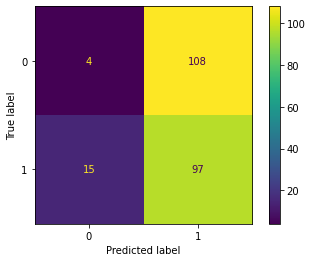

In [37]:
cm = confusion_matrix(dataset2_labels['True_Diagnosis'], dataset2_labels['Predicted_Diagnosis'])
cm_plot_labels = ['normal','sick']
ConfusionMatrixDisplay(cm).plot()

In [38]:
cr = classification_report(dataset2_labels['True_Diagnosis'], dataset2_labels['Predicted_Diagnosis'], output_dict=True)

In [39]:
dataset2_report = pd.DataFrame(cr).T

In [ ]:
train_images.shape[1:]

(150, 150, 3)

In [41]:
dataset2_report.to_csv('dataset2_predictions.csv')